In [1]:
!pip install -Uqq fastai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Download images of cats with different breed

In [3]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    # This function serves to get url of images from duckduckgo.com based on the keyword "term"
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Set up the data folder and download one photo for cat and dog respectively


In [4]:
path = Path("/content/drive/MyDrive/fastbook/jooCode/lesson1/data/")
path.mkdir(exist_ok=True, parents=True)
os.chdir("/content/drive/MyDrive/fastbook/jooCode/lesson1/data/")


In [5]:
os.getcwd()

'/content/drive/MyDrive/fastbook/jooCode/lesson1/data'

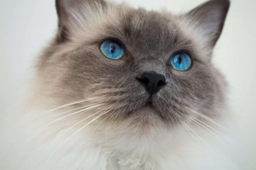

In [6]:
from fastdownload import download_url

download_url(search_images('Ragdolls Cat', max_images=1)[0],'R.jpg',show_progress=False)
from fastai.vision.all import *
im = Image.open('R.jpg')
im.to_thumb(256,256)

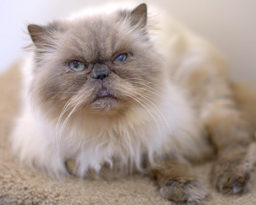

In [7]:
download_url(search_images('Persian Cat', max_images=1)[0], 'P.jpg', show_progress=False)
Image.open('P.jpg').to_thumb(256,256)

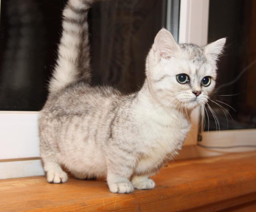

In [10]:
download_url(search_images('Scottish Fold Cat', max_images=1)[0], 'S.jpg', show_progress=False)
Image.open('S.jpg').to_thumb(256,256)

1.Downloading image data for cat and dogs. 

2.Resize the image data.

In [ ]:
searches = ['Ragdolls Cat','Persian Cat','Scottish Fold Cat']
downloadpath = Path('cat')
resizePath = Path('cat_Resize')
for o in searches:
    destDownload = (downloadpath/o)
    destResize = (resizePath/o)
    destDownload.mkdir(exist_ok=True, parents=True)
    destResize.mkdir(exist_ok=True, parents=True)
    download_images(destDownload, urls=search_images(f'{o}'))
    resize_images(destDownload, max_size=400, dest=destResize)

# Step2: Train the Model

Verify if any images cannot be open and remove these images.

In [12]:
path = Path("/content/drive/MyDrive/fastbook/jooCode/lesson1/data/cat_Resize")
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

**DataBlock**  
* define block  
* define getter (get_items,get_y..)  
* define splitter  
* define transform (item_tfms, batch_tfms..)  


Reference: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Slides.pdf

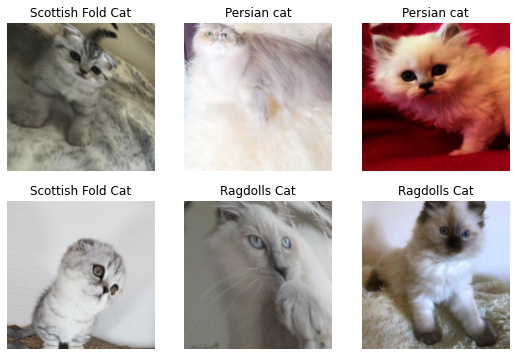

In [15]:
from fastai.vision import augment
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms = aug_transforms(mult=2)
).dataloaders(path)

dls.show_batch(max_n=6)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(15)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.668490,0.722533,0.241071,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.837062,0.566104,0.205357,00:05
1,0.792752,0.499771,0.169643,00:05
2,0.704529,0.503610,0.160714,00:07
3,0.662270,0.514262,0.142857,00:06
4,0.597776,0.569326,0.169643,00:04
5,0.551605,0.630408,0.178571,00:04
6,0.503240,0.574936,0.151786,00:04
7,0.462490,0.521114,0.160714,00:04
8,0.407484,0.526197,0.142857,00:05
9,0.373969,0.561091,0.151786,00:04


# Step3. Performance Analysis and Model Driven Data Cleaning


In [19]:
# Check the order of label
print(learn.dls.vocab)

['Persian cat', 'Ragdolls Cat', 'Scottish Fold Cat']


This is a: Persian cat.
Predicted Probability : 0.9855


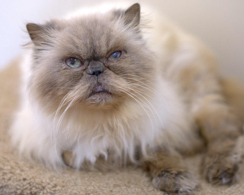

In [23]:
label,_,probs = learn.predict(PILImage.create('P.jpg'))
print(f"This is a: {label}.")
print(f"Predicted Probability : {probs[_]:.4f}")
Image.open('P.jpg').to_thumb(244)


This is a: Ragdolls Cat.
Predicted Probability : 1.0000


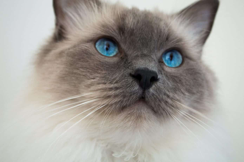

In [24]:
label,_,probs = learn.predict(PILImage.create('R.jpg'))
print(f"This is a: {label}.")
print(f"Predicted Probability : {probs[_]:.4f}")
Image.open('R.jpg').to_thumb(244)


This is a: Scottish Fold Cat.
Predicted Probability : 0.9992


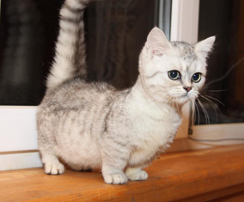

In [25]:
label,_,probs = learn.predict(PILImage.create('S.jpg'))
print(f"This is a: {label}.")
print(f"Predicted Probability : {probs[_]:.4f}")
Image.open('S.jpg').to_thumb(244)

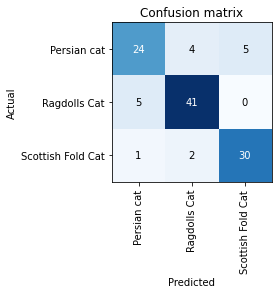

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

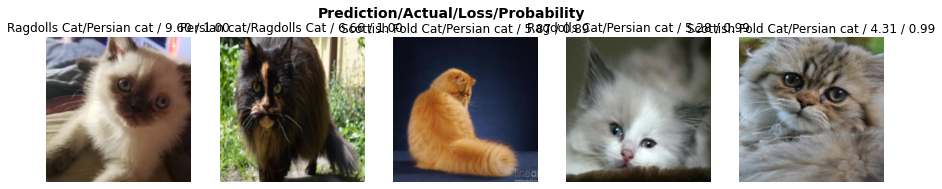

In [28]:
interp.plot_top_losses(5,nrows=1)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner 
cleaner = ImageClassifierCleaner(learn)
cleaner

In [33]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change():shutil.move(str(cleaner.fns[idx],path/cat))

# Step4: Export Model

In [ ]:
learn.export()